In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 한글 폰트
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프 마이너스 폰트 깨지는 문제 대처
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import mglearn

**파이프라인**
- 대부분 머신러닝 애플리케이션은 하나의 알고리즘으로 이뤄져 있지 않고, 여러 단계의 처리 과정과 머신러닝 모델이 연결되어 있음
    - 입력 데이터의 표현 형태에 매우 민감함 머신러닝 알고리즘이 많아 여러 단계에 거처 조정 필요
        - 데이터 스케일 조정
        - 특성 연결, 새로 생성 등
- Pipeline class
    - 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해줌
- Pipeline과 GridSearchCV를 함께 사용하여, 각 처리 단계에서 필요한 매개변수 탐색을 동시에 수행할 것임

# 데이터 전처리와 매개변수 선택 - 문제점(정보누설)
- 교차 검증에서 정보 누설에 의한 영향은 전처리 종류에 따라 다름
    - 검증 폴드를 이용해 데이터 스케일 조정하는 경우엔 심각한 문제까진 생기지 않음
    - 검증 폴드를 이용해 특성을 추출하거나 선택하면, 결과가 확연히 달라짐

In [2]:
# 데이터 분할, 데이터 스케일 변경, 모델 훈련 코드
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재 및 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값 계산
scaler = MinMaxScaler().fit(X_train)

# 훈련 데이터의 스케일 조정
X_train_scaled = scaler.transform(X_train)

# 모델 객체 생성
svm = SVC()
# 학습
svm.fit(X_train_scaled, y_train)

# test set의 스케일 조정 및 점수 계산
X_test_scaled = scaler.transform(X_test)
print('테스트 점수: {:.2f}'.format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


In [3]:
# 그리드 서치를 사용해 더 좋은 svc 매개변수 찾기
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 점수: {:.2f}'.format(grid.score(X_test_scaled, y_test)))
print('최적의 매개변수: ', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


이 코드에는 문제(함정)이 있음
- 데이터 스케일링(최솟값과 최댓값 계산)할 때, 학습을 위해 훈련 세트에 있는 모든 데이터를 사용함
    - 그 후, 스케일이 조정된 훈련 데이터에서 교차 검증을 수행함
    - 데이터 스케일을 조정할 때 검증 폴드에 들어있는 정보까지 이미 사용함..! (실제로는 몰라야하는데..!)
- 새로운 데이터가 관측되면(ex. validation, test set...) 이 데이터는 훈련 데이터의 스케일 조정에 사용되지 않은 것이라, 최솟값과 최댓값이 훈련 데이터와 다를 수 있음

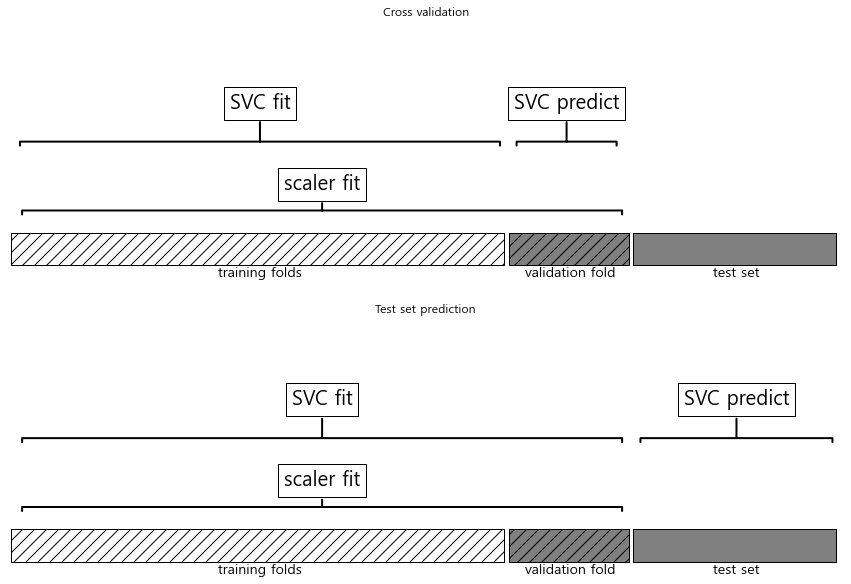

In [4]:
# 교차 검증 동안 데이터 처리와 최종 평가가 어떻게 다른지 보여주는 그림
mglearn.plots.plot_improper_processing()

- 교차 검증 반복 밖에서 이미 전처리가 됐을 때, 데이터 사용 형태
- 이렇기 때문에 교차 검증의 분할 방식은 모델이 새 데이터를 만났을 때, 올바로 반영하지 못하고 있음
- 검증 폴드 데이터의 정보가 모델 구축 과정에 이미 누설되었으므로, 교차 검증에서 최적의 매개변수를 찾지 못하고 낙관적인 결과를 만들게됨

# 파이프라인 구축하기
- 위 문제를 해결하려면 교차 검증의 분할이 모든 전처리 과정보다 앞서 이뤄져야함
    - 즉, 데이터셋의 정보를 이용하는 모든 처리과정은 교차 검증 반복 안에 있어야함(train set 부분에만 적용되야하므로)
- Pipeline은 여러 처리 단계를 하나의 추정기 형태로 묶어주는 class
    - fit, predict, score 메서드 제공
        - fit은 첫 번째 단계의 fit 메서드를 호출하여 훈련 데이터를 변환하고, ..., 마지막으로 변환된 데이터에 svm 모델을 훈련 시킴
        - score 메서드를 호출하면, 먼저 scaler를 사용하여 테스트 데이터를 변환하고, 변환된 데이터에 svm 모델의 score 메서드를 호출함
    - Pipeline을 사용하는 가장 일반적인 경우
        - 분류기 같은 지도 학습 모델과 (데이터 스케일 조정 같은) 전처리 단계를 연결할 때
- 파이프 라인을 사용하면 '전처리+분류'과정을 위해 작성해야할 코드가 줄어듬
- 가장 큰 장점은 cross_val_score나 GridSearchCV에 파이프라인을 하나의 추정기처럼 사용할 수 있다는 것

- 각 단계를 리스트로 전달하여 파이프라인 객체를 만듬
- 각 단계는 추정기의 객체와 임의의 이름('__'이중 밑줄 문자 외 모든 문자열 가능)으로 구성된 튜플(tuple)
    - [(이름, 객체),...]...

In [5]:
# '데이터 스케일 조정 - 모델 훈련'의 workflow를 Pipeline을 사용해 구현
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', MinMaxScaler()), ('svm',SVC())])   # 2단계 만듬. [(이름, 객체),...]

In [6]:
# fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

- fit은 첫 번째 단계의 fit 메서드를 호출하여 훈련 데이터를 변환하고, 마지막으로 변환된 데이터에 svm 모델을 훈련 시킴

In [7]:
# score
print('테스트 점수: {:.2f}'.format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


- score 메서드를 호출하면, 먼저 scaler를 사용하여 테스트 데이터를 변환하고, 변환된 데이터에 svm 모델의 score 메서드를 호출함

# 그리드 서치에 파이프 라인 적용 -  param_grid 위주
1. 탐색할 매개변수 그리드를 정의(매개변수 grid 딕셔너리의 키 -  생성시 주의!)
    - 각 매개변수가 파이프라인의 어떤 단계에 속한 것인지 알려줘야함! 
    - 속하는 단계의 이름 + '__' + '매개변수 이름' (단계의 이름과 매개변수 이름을 '__'로 연결해서 사용)
        -  ex. 'svm__C'
2. 이 매개변수 그리드와 파이프라인으로 GridSearchCV 객체를 만들면 됨


In [8]:
param_grid = {'svm__C':[0.001,0.01,0.1,1,10,100],
             'svm__gamma':[0.001,0.01,0.1,1,10,100]}

In [9]:
# 이 매개변수 grid로 GridSearchCV에 보통 처럼 사용할 수 있음
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print('최상의 교차 검증 정확도: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))
print('최적의 매개변수: ', grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수:  {'svm__C': 1, 'svm__gamma': 1}


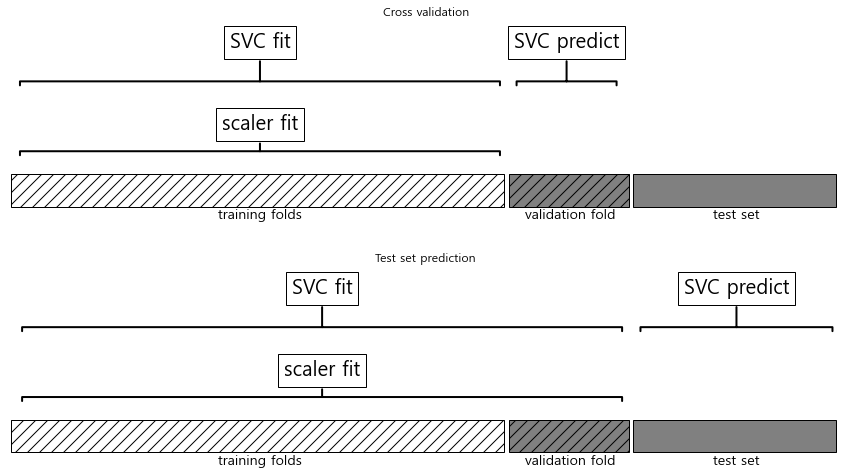

In [10]:
mglearn.plots.plot_proper_processing()

- 위 그림은 교차 검증 반복 안에서 전처리가 될 때 데이터 사용 형태를 나타낸 것
- 이 전에 본 그리드 서치와 다른 점은 교차 검증의 각 분할에 Scaler가 훈련 폴드에 매번 적용되어, 매개변수 검색 과정에서 검증 폴드의 정보가 누설되지 않은 것

# 파이프라인 인터페이스
- Pipeline은 어떤 추정기와도 연결할 수 있음 (전처리 분류에 국한 X)
    - 특성 추출, 특성 선택, 스케일 변경, 분류/회귀/군집 등을 모두 포함하는 파이프라인 생성 가능
    - 포함될 추청기 조건
        - 마지막 단계를 제외
            - 모두 transform 메서드를 가지고 있어야 함 (다음 단계를 위한 새로운 데이터 표현을 만들 수 있어야함)
        - 마지막 단계
            - 최소한 fit 메서드는 있어야함
            - 마지막 단계가 꼭 predict 함수를 가져야할 필요는 없은므로, 스케일 변환이나, PCA만 포함하는 파이프라인을 만들 수 있음
- Pipeline.fit 메서드 실행되는 동안 내부적으로
    - 파이프라인은 각 단계에서 이전 단계의 transform의 출력을 입력으로 받아, fit과 transform 메서드를 차례로 호출함(or fit_transform)
        - 마지막 단계를 빼고 fit과 transform 반복
    - 마지막 단계에서는 fit 메서드만 호출함
- Pipeline.predict
    - 예측 시에는 비슷한 방식으로 마지막 단계 이전까지 transform 메서드 호출한 다음, 마지막 단계에서 predict 호출

In [11]:
# 각 단계별 세부사항 대략 구현 pipeline.steps는 튜플
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform 반복
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [12]:
# 예측 시에는 비슷한 방식으로 마지막 단계 이전까지 transform 메서드 호출한 다음, 마지막 단계에서 predict 호출
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform 반복
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출
    return self.steps[-1][1].predict(X_transformed)

## make_pipleine을 사용한 파이프라인 생성
- make_pipeline 함수는 각 단계의 이름을 자동으로 생성해줌
    - 일반적으로 해당 파이썬 클래스 이름의 소문자 버전 이름을 만들어줌
    - 같은 파이썬 클래스를 여러 단계에서 사용하면, 이름 뒤에 숫자가 추가로 붙음
        - ex. 'standardscaler-1', standardscaler-2',..
    - .steps 속성으로 각 단계 이름, 정보 알 수 있음

In [13]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline([('scaler',MinMaxScaler()), ('svm', SVC(C=100))])

# 간소화 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [14]:
print('파이프라인 단계:\n', pipe_short.steps)

파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [16]:
# 같은 파이썬 클래스 여러 단계에서 사용 예시
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print('파이프라인 단계:\n', pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


- 'standardscaler-1', standardscaler-2'

## 단계 속성에 접근
- 단계 중 하나의 속성을 확인하고 싶을 때
- .named_steps 속성
    - 단계 이름을 키로 가진 딕셔너리
    - 파이프라인의 각 단계에 쉽게 접근할 수 있음

In [17]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용
pipe.fit(cancer.data)

# 'pca' 단계의 두 개 주성분을 추출
components = pipe.named_steps['pca'].components_
print('components.shape:', components.shape)

components.shape: (2, 30)


## 그리드 서치 안의 파이프라인 속성에 접근하기
- 파이프라인을 사용하는 주된 목적은 그리드 서치 때문 -> 그리드 서치 안에 있는 파이프라인의 단계에 접근할 때가 많음

In [18]:
from sklearn.linear_model import LogisticRegression

# 파이프라인 생성
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# LogisticRegression 매개변수 grid 생성
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

# cancer data set을 train/test set으로 나누고, 그리드 서치 적용
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)  # pipe line, param_grid, cv
grid.fit(X_train, y_train)

C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\qkrwl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

- 이 경우에 best_estimator_는 두 단계(standardscaler, logisticregression)를 가진 파이프라인이 됨
- logisticregression 단계에 접근 하려면 best_estimator_ + named_steps 속성 사용!

In [19]:
# 로지스틱 회귀 단계에 접근
print('로지스틱 회귀 단계:\n', grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계:
 LogisticRegression(C=1)


In [20]:
# 로지스틱 회귀 계수 조회
print('로지스틱 회귀 계수:\n', grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수:
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


# 전처리와 모델의 매개변수를 위한 그리드 서치
- 파이프라인을 사용하면 머신러닝 workflow에 필요한 모든 처리 단계를 하난의 추정기로 캡슐화할 수 있음
- 또 다른 장점으로, 회귀와 분류 같은 지도의 출력을 이용해서 전처리 매개변수를 조정할 수 있음

In [23]:
# 데이터 스케일 조정, "다항식 특성 선택", 리지 회귀 - 3단계 pipeline 생성
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

- 다항식 차수가 얼마나 되어야할 지 or 다항식이나 교차항이 필요한지 어떻게 알 수 있나?
    - 이상적인 방법: 분류 결과에 기초해서 degree 매개변수 선택
    - 파이프라인을 사용하면, Ridge의 alpha 매개변수와 함께 degree 매개변수를 탐색할 수 있음
        - 단계의 이름을 접두어로 사용한 매개변수 2개를 param_grid에 정의해야함

In [24]:
param_grid = {'polynomialfeatures__degree':[1,2,3], 
              'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

In [25]:
# 그리드 서치 적용
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [26]:
print('ridge best 매개변수 값:\n', grid.best_estimator_.named_steps['ridge'])

ridge best 매개변수 값:
 Ridge(alpha=10)


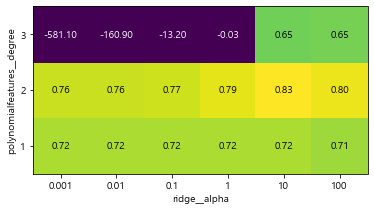

In [31]:
# 교차 검증 결과 heatmap으로 나타내기
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1), xlabel='ridge__alpha', ylabel='polynomialfeatures__degree',
                     xticklabels=param_grid['ridge__alpha'], yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

- 교차 검증 결과를 보면 2차항에서 좋은 결과가 나왔고, 3차항을 오히려 1,2차보다 결과가 나쁨
    - ridge score = R^2
    

In [32]:
print('최적의 매개변수: ', grid.best_params_)

최적의 매개변수:  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [34]:
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))

테스트 세트 점수: 0.77


In [39]:
# 다항식 특성이 없는 그리드 서치와 비교
param_grid = {'ridge__alpha': [0.001,0.01,0.1,1,10,100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print('다항식 특성이 없을 때 점수: {:.2f}'.format(grid.score(X_test, y_test)))

다항식 특성이 없을 때 점수: 0.63


- 파이프라인 캐싱을 사용하면 그리드 서치 속도를 개선할 수 있음

# 모델 선택을 위한 그리드 서치
- 파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있음
    - ex. StandardScaler, MinMaxScaler 중 어떤 것을 사용할지
    - 하지만 탐색 범위가 더 넓어지므로 주의 깊게 고려해야함
        - 모든 알고리즘을 시도해보는 것이 필수적인 머신러닝 전략은 아님
- 두 모델의 매개변수와 처리가 다를 때
    - 비대칭 매개변수 그리드 탐색에서 소개한 매개변수 그리드의 리스트 사용
    - 추정기 단계의 이름을 매개변수 이름으로 사용
- 파이프라인의 단계를 건너뛰어야할 때
    - 단계에 None을 할당
    - ex. 랜덤포레스트는 데이터 전처리 단계가 필요없음

In [40]:
# 랜덤포레스트 vs SVC (svc는 데이터 스케일 조정해야함)
# 2단계 - 1: 전처리, 2: 분류기

In [41]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [44]:
# 매개변수 grid - 두 모델의 매개변수와 처리가 다름을 고려
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier':[SVC()], 'preprocessing':[StandardScaler()], 
     'classifier__gamma':[0.001,0.01,0.1,1,10,100], 'classifier__C':[0.001,0.01,0.1,1,10,100]},
    {'classifier':[RandomForestClassifier(n_estimators=100)], 'preprocessing':[None], 
     'classifier__max_features':[1,2,3]}
]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 그리드 서치 객체 생성, fit
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10, gamma=0.01)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler()]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])

In [46]:
print('최적의 매개변수:\n{}\n'.format(grid.best_params_))
print('최상의 교차 검증 점수: {:.2f}'.format(grid.best_score_))
print('테스트 세트 점수: {:.2f}'.format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


## 중복 계산 피하기
- 대규모 그리드 서치를 수행하다보면, 종종 동일한 단계가 여러번 수행됨
    - ex. classifier 각 설정에 대해 StandardScaler가 다시 만들어짐
    - 비용이 많이든 변환 (PCA, NMF 등)을 사용하면, 계산 낭비가 심해짐
- 간단 해결책: memory 매개변수 사용
    - 파이프라인의 memory 매개변수를 사용하여, 계산 결과를 캐싱하는 것
    - 캐싱 활성화: memory='cache_folder'
- 하지만 2가지 단점이 있음
    1. 비교적 오랜시간이 걸리는(계산비용이 높은) 변환이어야 memory 매개변수를 사용하여 속도를 높이는 효과를 낼 수 있음
        - 단순한 데이터 스케일링 작업은 memory 매개변수 활성화하면, 오히려 느려질 수도
    2. n_jobs 매개변수가 캐싱을 방해함
        - 동일한 계산을 중복으로 수행할 수도 있음

> dask-ml 라이브러리에서 제공하는 GridSearchCV를 사용하면 이런 단점을 모두 피할 수 있음 

In [47]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier',SVC())], memory='cache_folder')

# 6장 요약
- 머신러닝 wordflow의 여러 처리 단계를 연결해주는 도구인 Pipeline
    - 실제 머신러닝 애플리케이션에서는 모델을 단독으로 사용하는 경우가 거의 없으며, 여러 처리 단계가 연속해서 이뤄짐
- 특히 교차 검증을 사용하여 모델을 평가하고, 그리드 서치를 사용하여 매개변수를 선택할 때, 모든 처리 단계를 pipeline으로 묶는 것은 올바른 평가를 위해 필수적!
- 코드를 간결하게 작성하도록 도와주며, 실수를 방지해줌
- 특성 추출, 전처리, 모델의 완벽한 조합을 찾는 것은 예술에 가까우므로, 어느 정도 시행 찾오가 필요
    - 실험 단계에서는 처리 단계를 너무 복잡하게 만들지 말고! 모델에 포함된 모든 요소가 꼭 필요한 것인지 평가해야함!